# Applied Machine Learning Techniques for Anomaly Transaction Detection in Mobile Banking



==============================================================================
### Import Dependencies
==============================================================================

In [1]:
######################################################
# Additional Lib
######################################################
import datetime
import os
from typing import Callable, Optional
import pandas as pd
import json
import warnings
warnings.filterwarnings("ignore")
######################################################
# Data Visualizations
######################################################
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns

######################################################
# Data Preprocessing
######################################################
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
######################################################
# Modelling
######################################################
from sklearn import preprocessing
import numpy as np
#import torch
#import torch_geometric.transforms as T
#from torch_geometric.loader import NeighborLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np
import gc
from tqdm.notebook import tqdm

==============================================================================
### LOADING DATA
==============================================================================

In [2]:
pd.set_option('display.max_columns', None)
path = '/content/hi_small_trxns.csv'
df = pd.read_csv(path)
df.head(10)
df = df.head(500000)
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0.0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0.0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0.0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0.0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0.0


In [3]:
###################################################################################################
# Data Visualization Function - Helpers
###################################################################################################

def format_title_output(text):
    return f"{'++' * 50}\n{text.upper()}\n{'++' * 50}\n"


#Null data with heatmap
def create_null_data_heatmap(
    title=None,
    rotate='horizontal',
    dataset=None
):
    try:
        plt.figure(figsize=(15,5))
        sns.heatmap(dataset.isnull(), cbar=False)
        plt.title(title, fontweight='bold')
        plt.xticks(rotation=rotate)
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HEATMAP: ", error)
        print("**"*50)


#Null data with heatmap
def create_correlation_heatmap(
    title=None,
    dataset=None
):
    try:
        plt.figure(figsize=(15,8))
        correlation = dataset.corr()
        correlation = (correlation)
        sns.heatmap(correlation,
                    xticklabels=correlation.columns.values,
                    yticklabels=correlation.columns.values,
                    annot=True
        )
        plt.title(title, fontweight='bold')
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HEATMAP: ", error)
        print("**"*50)

def create_boxplots(data, columns, ncols=2, figsize=(25, 6)):
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten() if nrows > 1 else axes
    for i, col in enumerate(columns):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(col)
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


def create_histogram(data, column, figsize=(15, 4), color="g", kde=False):
    try:
        plt.figure(figsize=figsize)
        sns.histplot(data[column], kde=kde, color=color).set_title(f'{column[0]} Distribution', fontweight='bold')
        plt.title(f"{column[0]} Distribution", fontweight='bold')
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HISTOGRAM: ", error)
        print("**"*50)

###################################################################################################
# Data Preprocessing - Helpers
###################################################################################################
def detect_outliers(data, columns):
    outlier_info = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = data[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        max_outlier = outliers[col].max() if not outliers.empty else None

        outlier_info[col] = {
            "max_outlier_value": max_outlier,
            "number_of_outliers": outliers.shape[0],
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
        }

    return outlier_info

In [4]:
# Check the dataset info
print(format_title_output("DATASET INFO"))
print(df.info())

print("\n\n\n")
print(format_title_output("DATASET LENGTH"))
print("ROWS: ", df.shape[0])
print("COLUMNS: ", df.shape[1])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET INFO
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Timestamp           500000 non-null  object 
 1   From Bank           500000 non-null  int64  
 2   Account             500000 non-null  object 
 3   To Bank             500000 non-null  int64  
 4   Account.1           500000 non-null  object 
 5   Amount Received     500000 non-null  float64
 6   Receiving Currency  500000 non-null  object 
 7   Amount Paid         500000 non-null  float64
 8   Payment Currency    500000 non-null  object 
 9   Payment Format      500000 non-null  object 
 10  Is Laundering       500000 non-null  float64
dtypes: float64(3), int

In [5]:
# rename the columns with lowercase and _ underscore if there is a space
print(format_title_output("DATASET NEW COLUMNS"))

df.columns = [col.lower().replace(" ", "_") for col in df.columns]
for i,j in enumerate(df.columns):
    print(i, " : ", j)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET NEW COLUMNS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

0  :  timestamp
1  :  from_bank
2  :  account
3  :  to_bank
4  :  account.1
5  :  amount_received
6  :  receiving_currency
7  :  amount_paid
8  :  payment_currency
9  :  payment_format
10  :  is_laundering


In [6]:
amount_consistency = df.loc[~(df['amount_received'] == df['amount_paid'])]
ccy_consistency = df.loc[~(df['receiving_currency'] == df['payment_currency'])]

print(format_title_output("AMOUNT CONSISTENCY - CREDIT & DEBIT"))
print(amount_consistency.shape)

print(format_title_output("CURRENCY CONSISTENCY - CREDIT & DEBIT"))
print(ccy_consistency.shape)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
AMOUNT CONSISTENCY - CREDIT & DEBIT
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(3137, 11)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
CURRENCY CONSISTENCY - CREDIT & DEBIT
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(3145, 11)


In [7]:
#Check the currency

print(format_title_output("RECEIVED CURRENCY"))
print(sorted(df['receiving_currency'].unique()))
print("\n\n")

print(format_title_output("PAYMENT CURRENCY"))
print(sorted(df['payment_currency'].unique()))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RECEIVED CURRENCY
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', 'Euro', 'Mexican Peso', 'Ruble', 'Rupee', 'Saudi Riyal', 'Shekel', 'Swiss Franc', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT CURRENCY
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', 'Euro', 'Mexican Peso', 'Ruble', 'Rupee', 'Saudi Riyal', 'Shekel', 'Swiss Franc', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']


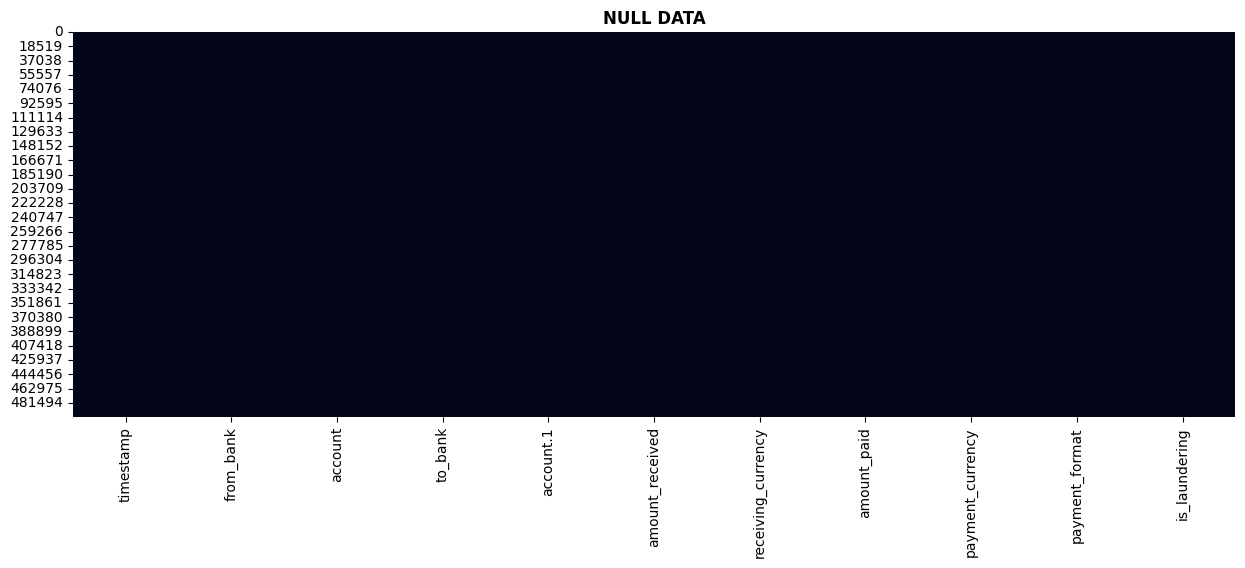

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NULL DATA NUMBER
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

timestamp             0
from_bank             0
account               0
to_bank               0
account.1             0
amount_received       0
receiving_currency    0
amount_paid           0
payment_currency      0
payment_format        0
is_laundering         0
dtype: int64


In [8]:
create_null_data_heatmap("NULL DATA", 'vertical', df)
print(format_title_output("NULL DATA NUMBER"))
print(df.isnull().sum())

In [9]:
negative_df = df[df['amount_paid'] < 0]
negative_df

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering


In [10]:
df.head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0.0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0.0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0.0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0.0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0.0


==============================================================================
### EDA
==============================================================================

In [11]:
# Check the outlier for the amount of each transaction
# Function to convert to USD
# from forex_python.converter import CurrencyRates
exchange_rates = {
    'Australian Dollar': 0.62124,  # AUD
    'Bitcoin': 23000.0,            # BTC (example rate)
    'Brazil Real': 0.1980,         # BRL
    'Canadian Dollar': 0.6876,     # CAD
    'Euro': 1.0362,                # EUR
    'Mexican Peso': 0.04835,       # MXN
    'Ruble': 0.01636,              # RUB
    'Rupee': 0.01153,              # INR
    'Saudi Riyal': 0.2667,         # SAR
    'Shekel': 0.2840,              # ILS
    'Swiss Franc': 1.0989,         # CHF
    'UK Pound': 1.2401,            # GBP
    'US Dollar': 1.0,              # USD
    'Yen': 0.006443,               # JPY
    'Yuan': 0.1391                 # CNY
}

# Function to convert to USD
def convert_to_usd(currency, amount):
    if currency in exchange_rates:
        return amount * exchange_rates[currency]
    else:
        print(f"Exchange rate for {currency} not found.")
        return amount

def create_bar_plot(df, column_name, title=None):
    plt.figure(figsize=(20, 5))
    sns.countplot(x=column_name, data=df, order=df[column_name].value_counts().index, palette='Set2')
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper() + " VALUE COUNTS"))
    print(df[column_name].value_counts())

def create_pie_plot(df, column_name, title=None):
    plt.figure(figsize=(8, 8))
    df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2', len(df[column_name].value_counts())))
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper() + " VALUE COUNTS"))
    print(df[column_name].value_counts())

def create_kde_plot(df, column_name, title=None, color='g'):
    plt.figure(figsize=(15, 5))
    sns.kdeplot(df[column_name], shade=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()

def create_kde_plot_with_log(df, column_name, title=None, color='r'):
    log_column = np.log1p(df[column_name])  # log(x+1) to avoid issues with zero values
    plt.figure(figsize=(15, 5))
    sns.kdeplot(log_column, shade=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper()))
    print(log_column.describe())

def create_histogram_with_bins(df, column_name, title=None, color='r', bins=20):
    plt.figure(figsize=(15, 5))
    sns.histplot(df[column_name], bins=bins, kde=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()

    print(format_title_output(title.upper()))
    print(df[column_name].describe())

def create_transaction_line_plot(df, date_column, amount_column, title=None):
    df[date_column] = pd.to_datetime(df[date_column])
    daily_transactions = df.groupby(df[date_column].dt.date)[amount_column].sum().reset_index()
    plt.figure(figsize=(15, 5))
    sns.lineplot(x=daily_transactions[date_column], y=daily_transactions[amount_column],
                 marker='o', color='b', linewidth=2, markersize=8, label='Transaction Amount')
    plt.title(title, fontweight='bold', color='#065164', fontsize=12)
    plt.xlabel('Date', fontsize=12, color='#065164')
    plt.ylabel('Total Transaction Amount', fontweight='bold', fontsize=12, color='#065164')
    plt.show()


In [12]:
# Convert to the USD currency based on the exchange rate
df['usd_amount'] = df.apply(lambda row: convert_to_usd(row['payment_currency'], row['amount_paid']), axis=1)
none_us_dollar = df.loc[(df['payment_currency'] != 'US Dollar')]
none_us_dollar.head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,usd_amount
1155,2022/09/01 00:16,220,8001C8C51,1420,8003093C1,0.025852,Bitcoin,0.025852,Bitcoin,Bitcoin,0.0,594.596000
1174,2022/09/01 00:22,1362,80030A870,11,80064C9B0,52.110000,Euro,52.110000,Euro,Credit Card,0.0,53.996382
1467,2022/09/01 00:15,1,80005C0A1,1588,8003AC471,0.016891,Bitcoin,0.016891,Bitcoin,Bitcoin,0.0,388.493000
3940,2022/09/01 00:08,513,8006538E1,1688,8006DD361,1.621978,Bitcoin,1.621978,Bitcoin,Bitcoin,0.0,37305.494000
6302,2022/09/01 00:19,1688,800646381,1674,800B1B1B1,0.045449,Bitcoin,0.045449,Bitcoin,Bitcoin,0.0,1045.327000


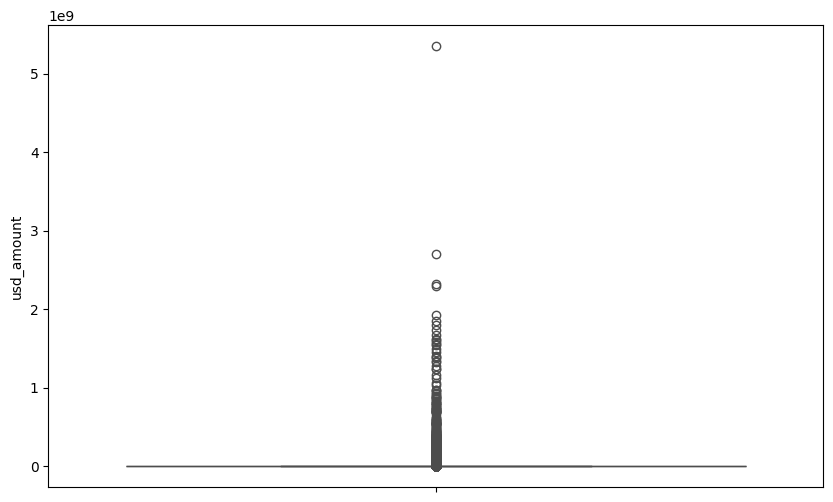

In [13]:
#check outlier of the text length
f, axes = plt.subplots(ncols=1, figsize=(10, 6))
sns.boxplot(y=df['usd_amount'] ,color='grey')
plt.show()

In [14]:
outliers = detect_outliers(
    df,
    ['usd_amount'],
)
print(format_title_output("OUTLIERS DETECTION - AMOUNT RECEIVED & PAID"))
print(json.dumps(outliers, indent=4))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
OUTLIERS DETECTION - AMOUNT RECEIVED & PAID
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

{
    "usd_amount": {
        "max_outlier_value": 5351188958.74,
        "number_of_outliers": 87340,
        "lower_bound": -25885.8353595,
        "upper_bound": 43206.5789325
    }
}


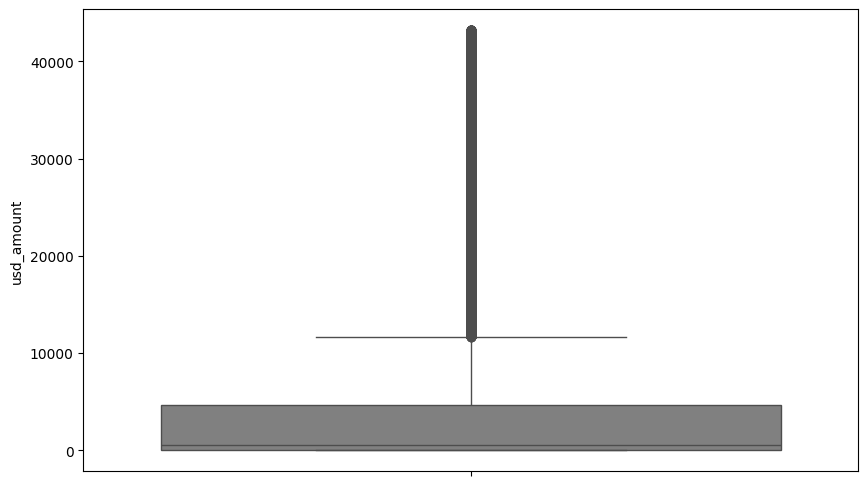

In [15]:
#Remove outlierts
df_no_outliers = df[df['usd_amount'] <= outliers['usd_amount']['upper_bound']]
df_no_outliers = df_no_outliers[df_no_outliers['usd_amount'] > 0]

#check outlier of the text length
f, axes = plt.subplots(ncols=1, figsize=(10, 6))
sns.boxplot(y=df_no_outliers['usd_amount'] ,color='grey')
plt.show()

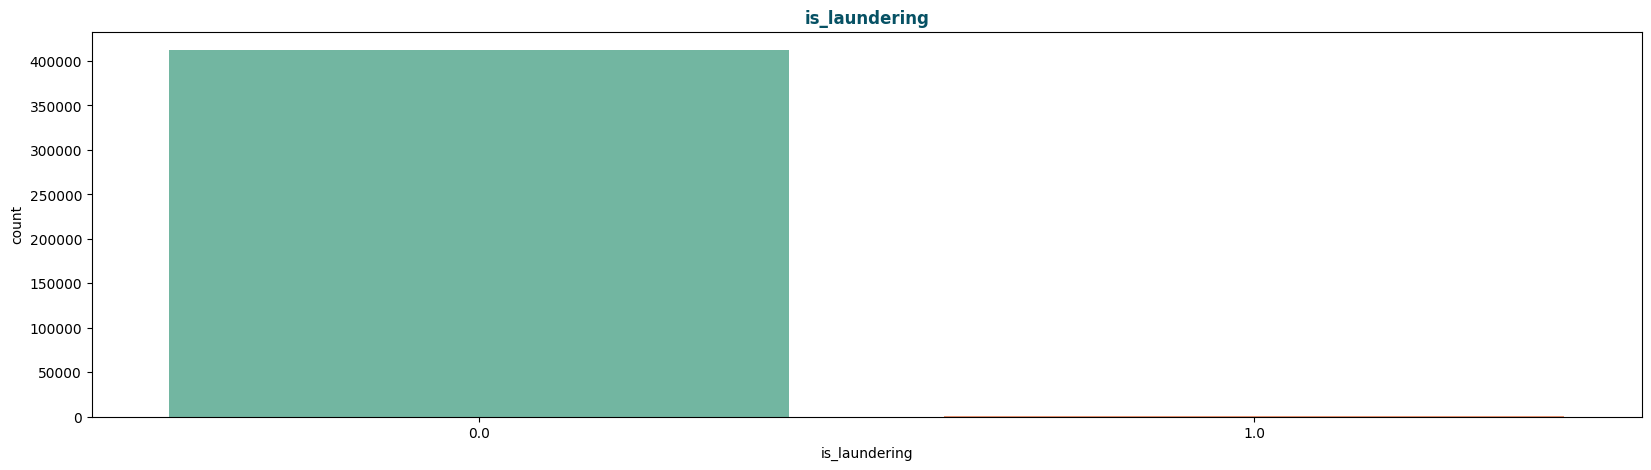

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
IS_LAUNDERING VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

is_laundering
0.0    412475
1.0       185
Name: count, dtype: int64


In [18]:
create_bar_plot(
    df=df_no_outliers,
    column_name='is_laundering',
    title='is_laundering'
)

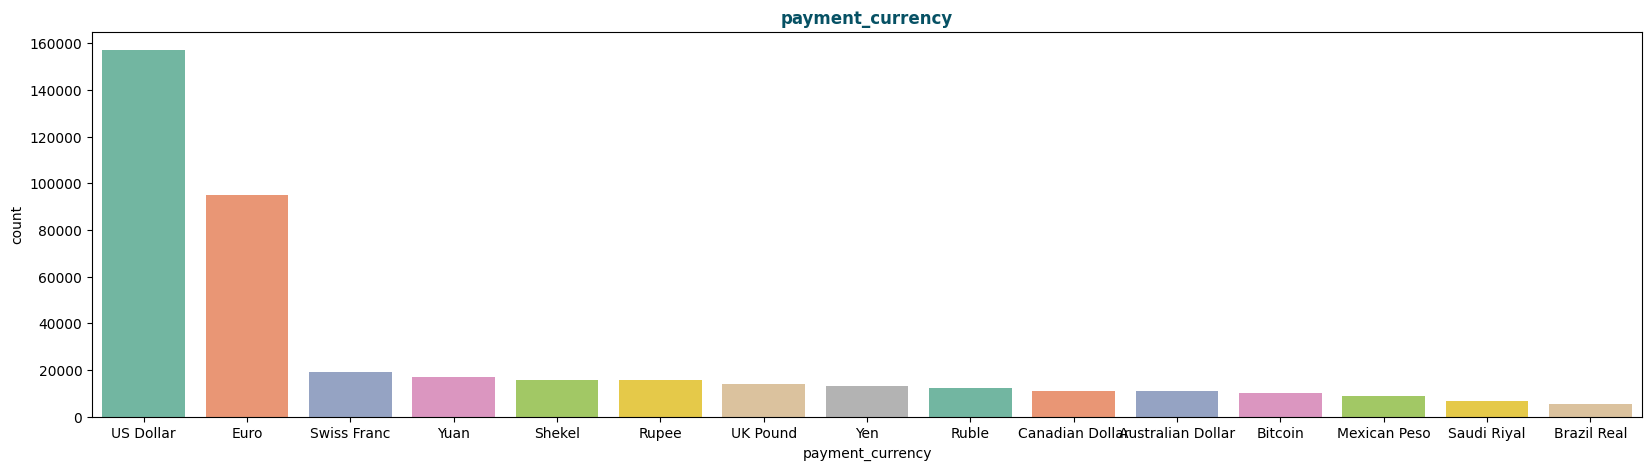

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT_CURRENCY VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

payment_currency
US Dollar            157109
Euro                  95053
Swiss Franc           19036
Yuan                  17146
Shekel                15712
Rupee                 15611
UK Pound              13978
Yen                   13147
Ruble                 12196
Canadian Dollar       11078
Australian Dollar     10995
Bitcoin               10257
Mexican Peso           9044
Saudi Riyal            6833
Brazil Real            5465
Name: count, dtype: int64


In [19]:
create_bar_plot(
    df=df_no_outliers,
    column_name='payment_currency',
    title='payment_currency'
)

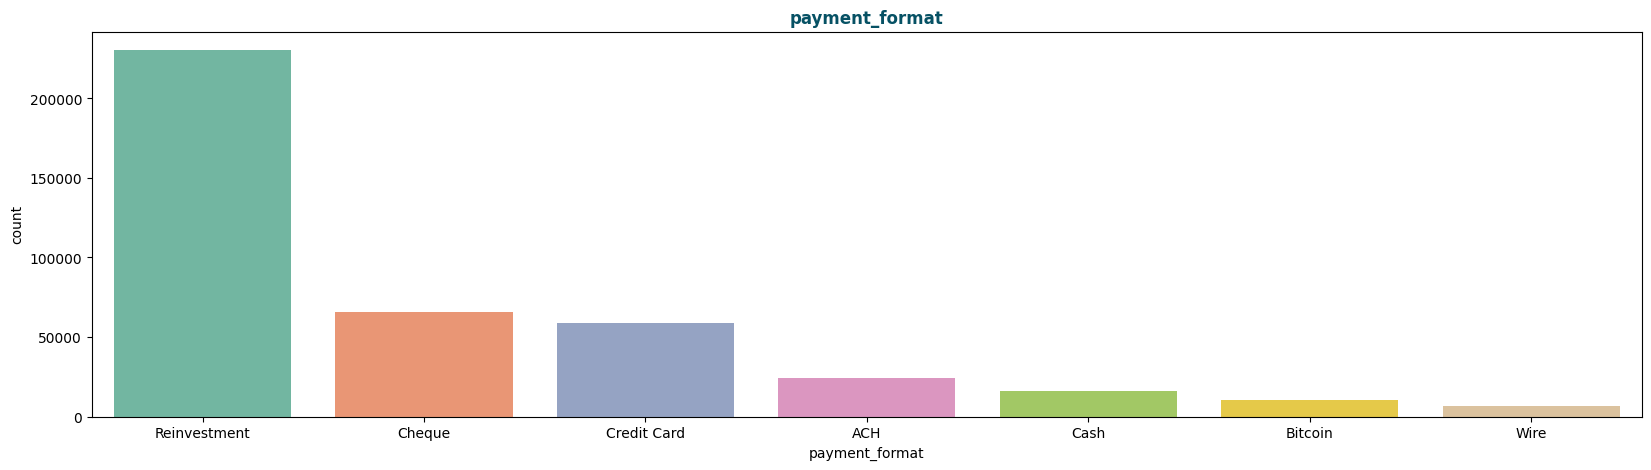

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT_FORMAT VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

payment_format
Reinvestment    230406
Cheque           65640
Credit Card      58964
ACH              24488
Cash             16046
Bitcoin          10254
Wire              6862
Name: count, dtype: int64


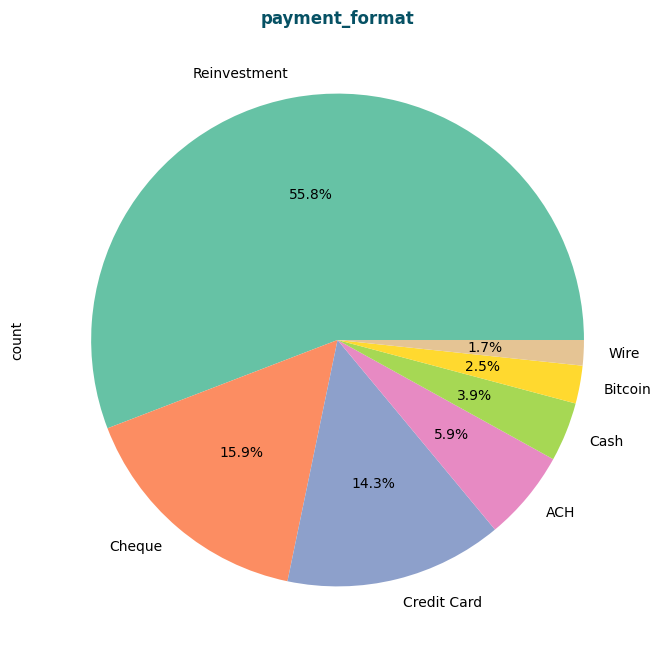

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT_FORMAT VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

payment_format
Reinvestment    230406
Cheque           65640
Credit Card      58964
ACH              24488
Cash             16046
Bitcoin          10254
Wire              6862
Name: count, dtype: int64


In [20]:
create_bar_plot(
    df=df_no_outliers,
    column_name='payment_format',
    title='payment_format'
)

create_pie_plot(
    df=df_no_outliers,
    column_name='payment_format',
    title='payment_format'
)

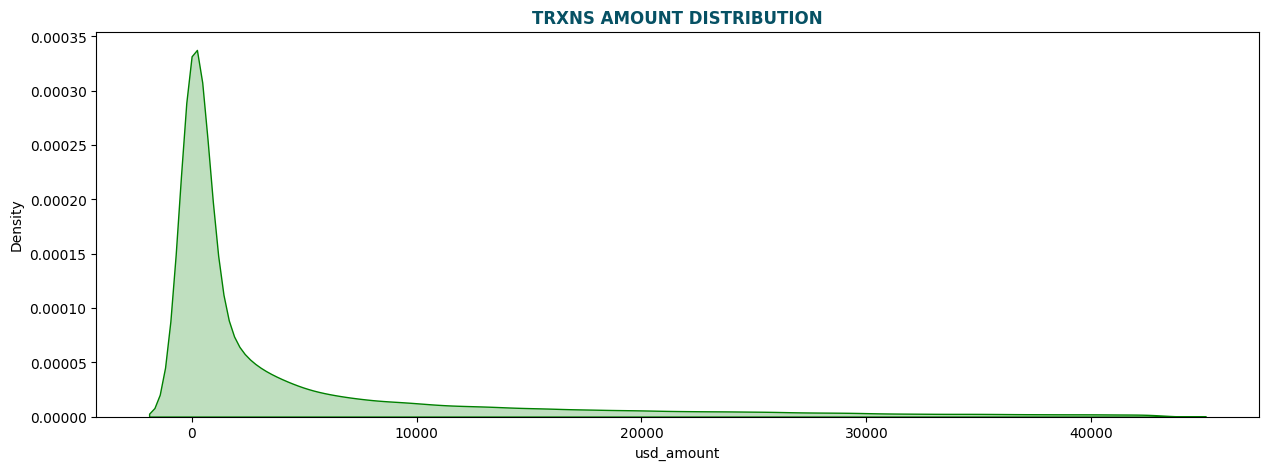

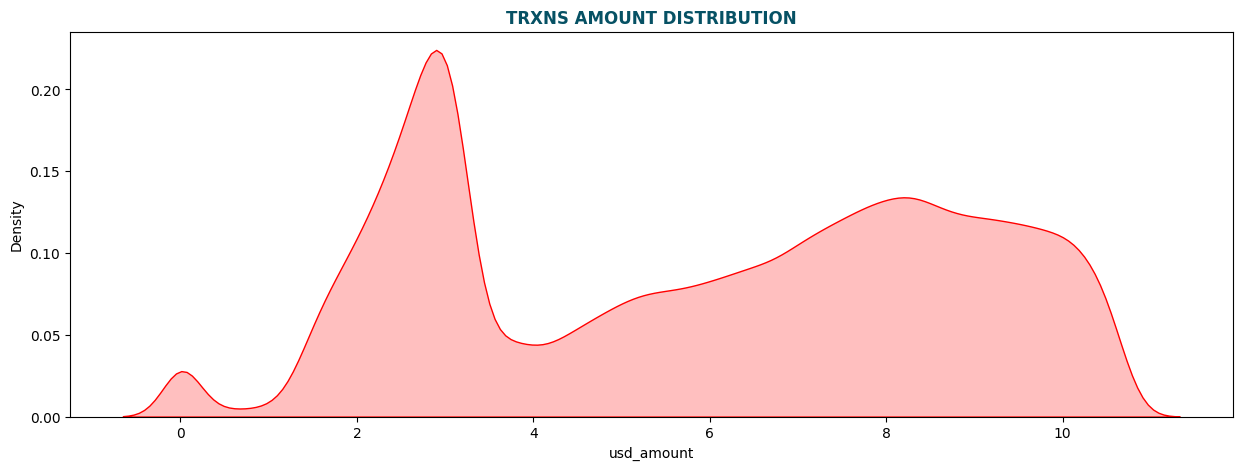

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
TRXNS AMOUNT DISTRIBUTION
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

count    412660.000000
mean          5.919690
std           2.887762
min           0.000064
25%           3.005187
50%           6.283280
75%           8.452836
max          10.673768
Name: usd_amount, dtype: float64


In [21]:
create_kde_plot(df_no_outliers, 'usd_amount', 'TRXNS AMOUNT DISTRIBUTION')
create_kde_plot_with_log(df_no_outliers, 'usd_amount', 'TRXNS AMOUNT DISTRIBUTION')

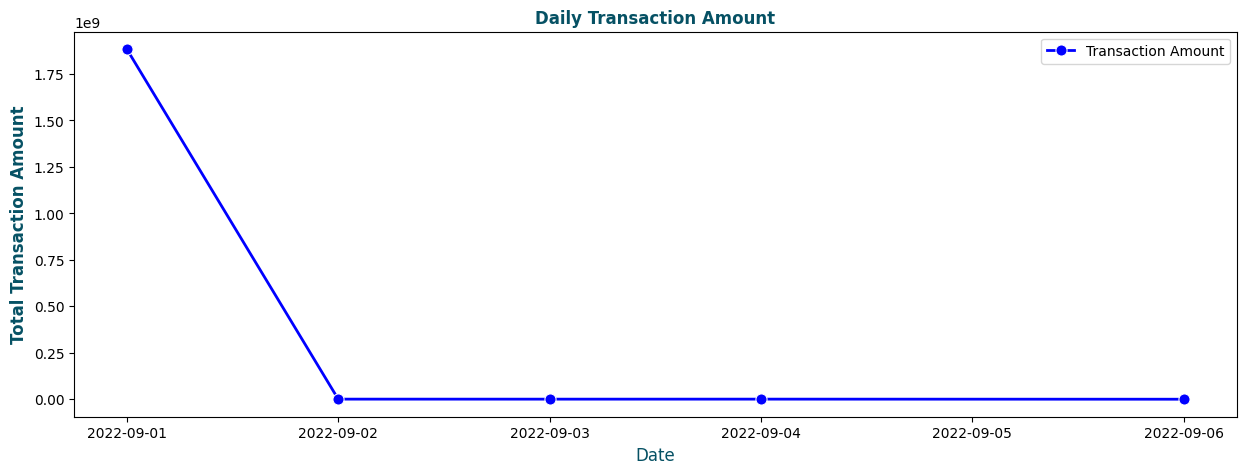

In [22]:
create_transaction_line_plot(df_no_outliers, 'timestamp', 'usd_amount', 'Daily Transaction Amount')

==============================================================================
### DATA PREPROCESSING
==============================================================================

In [23]:
def create_numerical_pipeline():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ])
def create_categorical_pipeline():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinalencoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])
def create_transformer(numerical_features, categorical_features):
    return ColumnTransformer(
        transformers=[
            ("num_pipeline", create_numerical_pipeline(), numerical_features),
            ("cat_pipeline", create_categorical_pipeline(), categorical_features)
        ],
        remainder='drop'  # Changed from 'passthrough' to 'drop'
    )

def preprocess_data(df):
    new_df = df.copy()
    new_df['is_laundering'] = new_df['is_laundering'].fillna('0').astype(str)

    # Identify numerical and categorical columns
    numerical_features = new_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = new_df.select_dtypes(include=['object']).columns.tolist()

    # Remove target variable from features if present
    if 'is_laundering' in numerical_features:
        numerical_features.remove('is_laundering')
    if 'is_laundering' in categorical_features:
        categorical_features.remove('is_laundering')

    # Prepare X and y
    X = new_df.drop(columns=['is_laundering'])
    y = new_df['is_laundering']

    # Create and fit transformer
    transformer = create_transformer(
        numerical_features=numerical_features,
        categorical_features=categorical_features
    )

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Apply transformations
    X_train_transformed = transformer.fit_transform(X_train)
    X_test_transformed = transformer.transform(X_test)

    return X_train_transformed, X_test_transformed, y_train, y_test, transformer

In [24]:
# start preprocessing on none outliers dataframe first
new_df = df_no_outliers.copy()

In [26]:
print(format_title_output("RECHECK THE DATA INFO"))
print(new_df.info())

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RECHECK THE DATA INFO
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

<class 'pandas.core.frame.DataFrame'>
Index: 412660 entries, 0 to 499999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           412660 non-null  datetime64[ns]
 1   from_bank           412660 non-null  int64         
 2   account             412660 non-null  object        
 3   to_bank             412660 non-null  int64         
 4   account.1           412660 non-null  object        
 5   amount_received     412660 non-null  float64       
 6   receiving_currency  412660 non-null  object        
 7   amount_paid         412660 non-null  float64       
 8   payment_currency    412660 non-null  object        
 9   payment_format      412660 non-null  

In [27]:
print(format_title_output("DROP THE UNNESESSAR COLUMNS"))
columns_to_drop = ['timestamp', 'amount_paid', 'payment_currency', 'amount_received']
new_df.drop(columns_to_drop, axis=1, inplace=True)
new_df.head()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DROP THE UNNESESSAR COLUMNS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



,from_bank,account,to_bank,account.1,receiving_currency,payment_format,is_laundering,usd_amount
0,10,8000EBD30,10,8000EBD30,US Dollar,Reinvestment,0.0,3697.34
1,3208,8000F4580,1,8000F5340,US Dollar,Cheque,0.0,0.01
2,3209,8000F4670,3209,8000F4670,US Dollar,Reinvestment,0.0,14675.57
3,12,8000F5030,12,8000F5030,US Dollar,Reinvestment,0.0,2806.97
4,10,8000F5200,10,8000F5200,US Dollar,Reinvestment,0.0,36682.97


In [28]:
new_df['from_bank'] = new_df['from_bank'].fillna('unknown').astype(int)
new_df['to_bank'] = new_df['to_bank'].fillna('unknown').astype(int)
new_df['account'] = new_df['account'].fillna('unknown').astype(str)
new_df['account.1'] = new_df['account.1'].fillna('unknown').astype(str)
new_df['is_laundering'] = new_df['is_laundering'].fillna('0').astype(str)


numerical_features = new_df.select_dtypes(exclude="object").columns.tolist()
categorical_features = new_df.select_dtypes(include = "object").columns.tolist()
print(format_title_output("NUMERICAL COLUMNS"))
for i,j in enumerate(numerical_features):
    print(i, ":" , j)
print("\n\n")
print(format_title_output("CLASSIFICATIONS COLUMNS"))
for i,j in enumerate(categorical_features):
    print(i, ":" , j)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NUMERICAL COLUMNS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

0 : from_bank
1 : to_bank
2 : usd_amount



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
CLASSIFICATIONS COLUMNS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

0 : account
1 : account.1
2 : receiving_currency
3 : payment_format
4 : is_laundering


In [29]:
print(format_title_output("FINAL DROP DUPLICATIONS"))
new_df.drop_duplicates(inplace=True)
print(new_df.shape)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
FINAL DROP DUPLICATIONS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(412659, 8)


In [30]:
print(format_title_output("FINAL DATA PROCESSED"))
X_train, X_test, y_train, y_test, transformer = preprocess_data(new_df)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
FINAL DATA PROCESSED
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

X_train shape: (330127, 7)
X_test shape: (82532, 7)
y_train shape: (330127,)
y_test shape: (82532,)


In [31]:
X_train[100]

array([ 1.57634345e-01,  1.60396521e+00, -1.14327562e-01,  2.01972000e+05,
        1.93745000e+05,  4.00000000e+00,  4.00000000e+00])

==============================================================================
### MODELLING TRAINING
==============================================================================

In [32]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

def create_confusion_matrix_plot(conf_matrix, model_name):
    plt.figure(figsize=(7, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Laundering', 'Laundering'],
                yticklabels=['Not Laundering', 'Laundering'])
    plt.title(f'Confusion Matrix - {model_name}', fontweight='bold', color='#065164')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"\n{model_name} Results:")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    # Plot confusion matrix
    create_confusion_matrix_plot(conf_matrix, model_name)

    return model, accuracy

def train_xgboost_with_monitoring(
    X_train,
    X_test,
    y_train,
    y_test,
    params={
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 5,
        'random_state': 42
    },
    early_stopping_rounds=10,
    memory_threshold_gb=8
):

    # Convert data to numpy arrays if they're pandas objects
    X_train = X_train.values if hasattr(X_train, 'values') else X_train
    X_test = X_test.values if hasattr(X_test, 'values') else X_test
    y_train = y_train.values if hasattr(y_train, 'values') else y_train
    y_test = y_test.values if hasattr(y_test, 'values') else y_test

    # Calculate approximate memory requirement
    n_samples, n_features = X_train.shape
    estimated_memory_gb = (n_samples * n_features * 8) / (1024**3) * 3  # Rough estimate

    if estimated_memory_gb > memory_threshold_gb:
        print(f"Warning: Estimated memory usage ({estimated_memory_gb:.2f}GB) exceeds threshold ({memory_threshold_gb}GB)")
        print("Consider reducing batch size or using GPU training")
        return None, None

    # Create DMatrix objects for better memory efficiency
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Clear unnecessary objects
    del X_train, y_train
    gc.collect()

    # Set up evaluation list
    evallist = [(dtrain, 'train'), (dtest, 'eval')]

    # Prepare XGBoost parameters
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',  # More memory efficient
        **params
    }

    # Train with progress bar
    print("Training XGBoost model...")
    model = xgb.train(
        xgb_params,
        dtrain,
        params['n_estimators'],
        evallist,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False,
        callbacks=[xgb.callback.ProgressBar()]
    )

    # Make predictions
    y_pred = model.predict(dtest)
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)

    print(f"\nTest Accuracy: {accuracy:.4f}")

    # Memory cleanup
    del dtrain, dtest
    gc.collect()

    return model, accuracy

In [33]:
print(format_title_output("output encoder"))
print("Y Train: ", y_train_encoded)
print("Y Test: ", y_test_encoded)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
OUTPUT ENCODER
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Y Train:  [0 0 0 ... 0 0 0]
Y Test:  [0 0 0 ... 0 0 0]


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
MODEL TRAINING - LOGISTIC REGRESSION
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


Logistic Regression Results:
Accuracy: 0.9995

Confusion Matrix:
[[82493     0]
 [   39     0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82493
           1       0.00      0.00      0.00        39

    accuracy                           1.00     82532
   macro avg       0.50      0.50      0.50     82532
weighted avg       1.00      1.00      1.00     82532



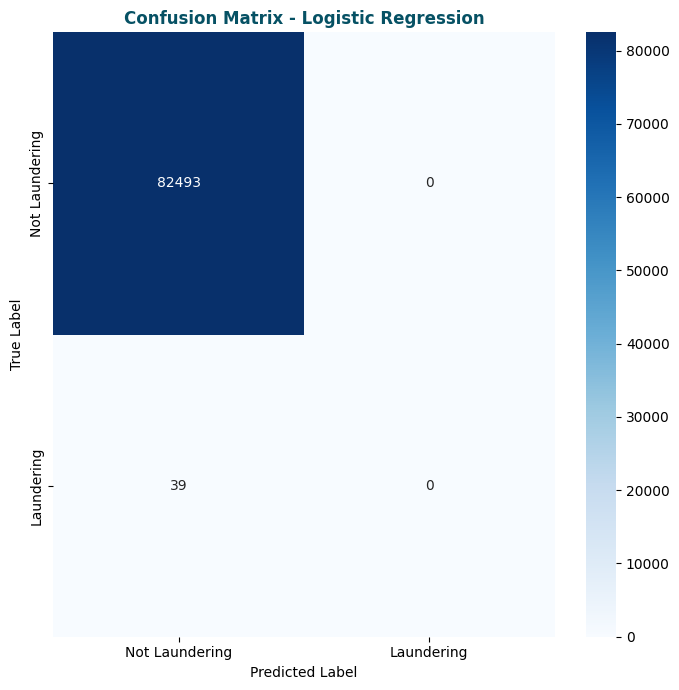

In [34]:
# 1. Logistic Regression
print(format_title_output("model training - logistic regression"))

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model, lr_accuracy = train_and_evaluate_model(
    lr_model,
    X_train,
    X_test,
    y_train_encoded,
    y_test_encoded,
    "Logistic Regression"
)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
MODEL TRAINING - XGBOOST
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


XGBoost Results:
Accuracy: 0.9988

Confusion Matrix:
[[82420    73]
 [   29    10]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     82493
           1       0.12      0.26      0.16        39

    accuracy                           1.00     82532
   macro avg       0.56      0.63      0.58     82532
weighted avg       1.00      1.00      1.00     82532



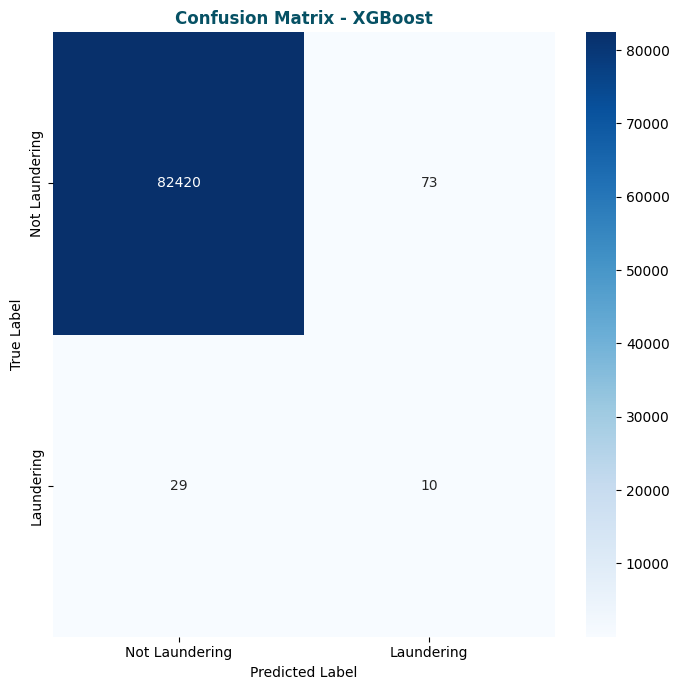

In [35]:
# 2. XGBoost
print(format_title_output("model training - XGBoost"))

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model, xgb_accuracy = train_and_evaluate_model(
    xgb_model,
    X_train,
    X_test,
    y_train_encoded,
    y_test_encoded,
    "XGBoost"
)

In [36]:
print(format_title_output("model comparison"))

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

feature_importance = pd.DataFrame({
    'feature': range(X_train.shape[1]),
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features (XGBoost):")
print(feature_importance.head(10))

results_df = pd.DataFrame({
    'Actual': label_encoder.inverse_transform(y_test_encoded),
    'LogisticRegression_Pred': label_encoder.inverse_transform(lr_model.predict(X_test)),
    'XGBoost_Pred': label_encoder.inverse_transform(xgb_model.predict(X_test))
})

print("\nSample Predictions:")
print(results_df.head())

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
MODEL COMPARISON
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Logistic Regression Accuracy: 0.9995
XGBoost Accuracy: 0.9988

Top 10 Most Important Features (XGBoost):
   feature  importance
6        6    0.539861
3        3    0.102283
4        4    0.100611
0        0    0.098473
2        2    0.065149
1        1    0.055719
5        5    0.037905

Sample Predictions:
  Actual LogisticRegression_Pred XGBoost_Pred
0    0.0                     0.0          0.0
1    0.0                     0.0          0.0
2    0.0                     0.0          0.0
3    0.0                     0.0          0.0
4    0.0                     0.0          0.0
